<a href="https://colab.research.google.com/github/gustavoleo/Analysis-Services/blob/master/Copy_of_Lesson_3_Pagination_%26_Authentication_%26_dlt_Configuration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recap of [Lesson 2](https://colab.research.google.com/drive/1tc94GvIoYXmYrjUibDhY_9iPR5zA0Eyw?usp=sharing) 👩‍💻🚀**

1.  Used `@dlt.resource` to load and query data like lists, dataframes, and REST API responses into DuckDB.  
2.  Grouped multiple resources into a single `@dlt.source` for better organization and efficiency.  
3.  Used `@dlt.transformer` to process and enrich data between resources.  

Next: Dive deeper into building dlt pipelines using pagination, authentication and dlt configuration! 🚀

---

# **Pagination & Authentication & dlt Configuration** 🤫🔩

**Here, you will learn how to:**
- Use pagination for RestAPIs.
- Use environment variables to handle both secrets & configs.
- Add values to `secrets.toml` or `config.toml`.

To read more about credentails refer to [dlt documentation](https://dlthub.com/docs/general-usage/credentials/) here.

In previous lesson we loaded data from GitHub API  to DuckDB,

In [ ]:
%%capture
!pip install dlt

In [ ]:
import dlt
from dlt.sources.helpers import requests


# define dlt resources
@dlt.resource
def github_events():
    url = "https://api.github.com/orgs/dlt-hub/events"
    response = requests.get(url)
    yield response.json()


# define dlt pipeline
pipeline = dlt.pipeline(destination="duckdb")

# run dlt pipeline
load_info = pipeline.run(github_events)
print(load_info)

# explore loaded data
pipeline.dataset(dataset_type="default").github_events.df()

You could notice that we received only 1 page, only 30 records. But this endpoint has muuuch more records in total. To get all the pages you should use a pagination.

When working with APIs like GitHub, data is often returned in pages. Pagination allows you to retrieve all the data when an endpoint limits how much can be fetched at once.

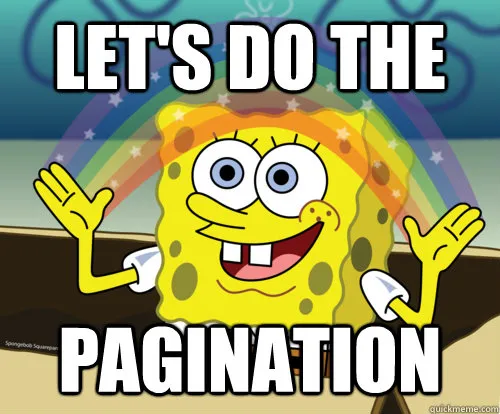

## **Pagination**

GitHub has very good documentation, so it is not difficult to go through the documentation and find the relevant page: [Pagination.](https://docs.github.com/en/rest/using-the-rest-api/using-pagination-in-the-rest-api?apiVersion=2022-11-28)

It says:
>You can use the `link` header from the response to request additional pages of data.

>The link header contains URLs that you can use to fetch additional pages of results. For example, the previous, next, first, and last page of results.

**GitHub API Pagination example**

The GitHub API provides the `per_page` and `page` query parameters:

* `per_page`: The number of records per page (up to 100).
* `page`: The page number to retrieve.

In [ ]:
import requests
response = requests.get("https://api.github.com/orgs/dlt-hub/events?per_page=10&page=1")
response.headers

Gotcha! We can see 'Link' in the headers. To get this link we can alternatively use `response.links`:

In [ ]:
import requests
response = requests.get("https://api.github.com/orgs/dlt-hub/events?per_page=10&page=1")
response.links

### **dlt RESTClient**

The response includes a 'Link' header for navigating to the next page.
So now we can implement a pagination!

When working with APIs, you could implement pagination using only Python and the requests library. While this approach works, it often requires writing boilerplate code for tasks like managing authentication, constructing URLs, and handling pagination logic.

More about how to build pagination with Python and `requests`:

* [Link 1](https://farnamdata.com/api-pagination)

* [Link 2](https://www.klamp.io/blog/python-requests-pagination-for-efficient-data-retrieval)

**But!** In this lesson, we’re gonna use dlt's **[RESTClient](https://dlthub.com/docs/general-usage/http/rest-client)** to handle pagination seamlessly when working with REST APIs like GitHub.


**Why use RESTClient?**

RESTClient is part of dlt's helpers, making it easier to interact with REST APIs by managing repetitive tasks such as:

* Authentication
* Query parameter handling
* Pagination

This reduces boilerplate code and lets you focus on your data pipeline logic.

**Here’s how to fetch paginated data:**
1. Import RESTClient
2. Create the RESTClient instance
3. Use the `paginate` method to iterate through all pages of data.

In [ ]:
from dlt.sources.helpers.rest_client import RESTClient


client = RESTClient(
    base_url="https://api.github.com",
)

for page in client.paginate("orgs/dlt-hub/events"):
    print(page)

Pagination type was detected automatically, but you can explicitly provide it:

In [ ]:
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.paginators import HeaderLinkPaginator

client = RESTClient(
    base_url="https://api.github.com",
    paginator=HeaderLinkPaginator(),
)

The full list of available paginators you can see in offcial [dlt documentation](https://dlthub.com/docs/general-usage/http/rest-client#paginators).


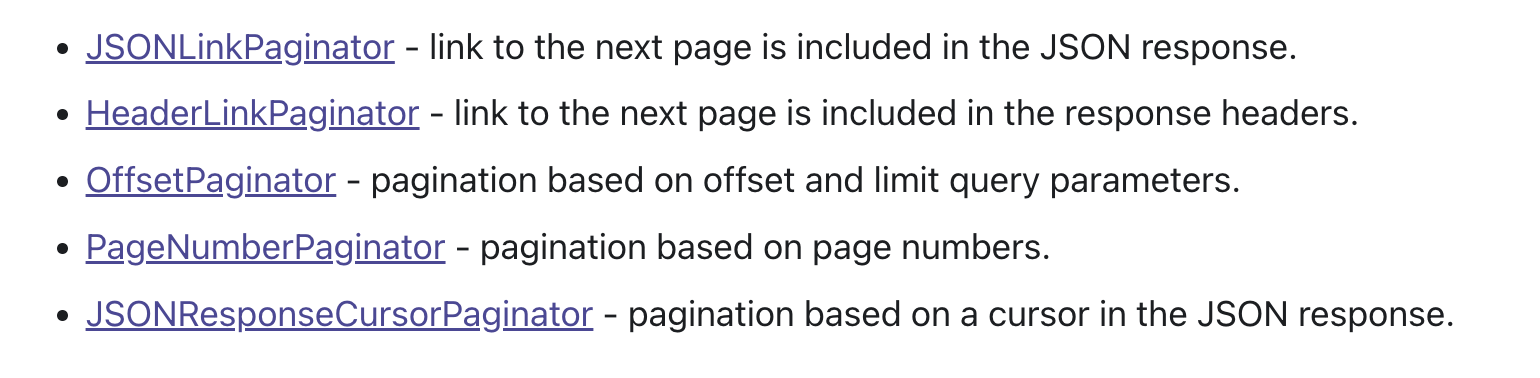

The events endpoint does not have as much data, specially if you compare it with the stargazers endpoint for the dlt repo.

If you run the pipeline for stargazers endpoint, there is a high chance that you face the **rate limit error**.

In [ ]:
from dlt.sources.helpers.rest_client import RESTClient


client = RESTClient(
    base_url="https://api.github.com",
)

for page in client.paginate("repos/dlt-hub/dlt/stargazers"):
    print(page)

### **Exercise 1: Pagination with RESTClient**
Explore the cells above and answer the question below.
#### Question
What type of pagination should we use for the GitHub API?

## **Authentication**

To avoid this error you can use [GitHub API Authentication](https://docs.github.com/en/rest/authentication/authenticating-to-the-rest-api?apiVersion=2022-11-28):

1. Login to your GitHub account.
2. Generate [API token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token) (classic one!).
2.  Use it as an access token for GitHub API.

**! ATTENTION !**

Never share your credentials in public and never hard-code them in your code. Use **environment variables** or **dlt secrets.toml**.

Create an environment variable for your access token.

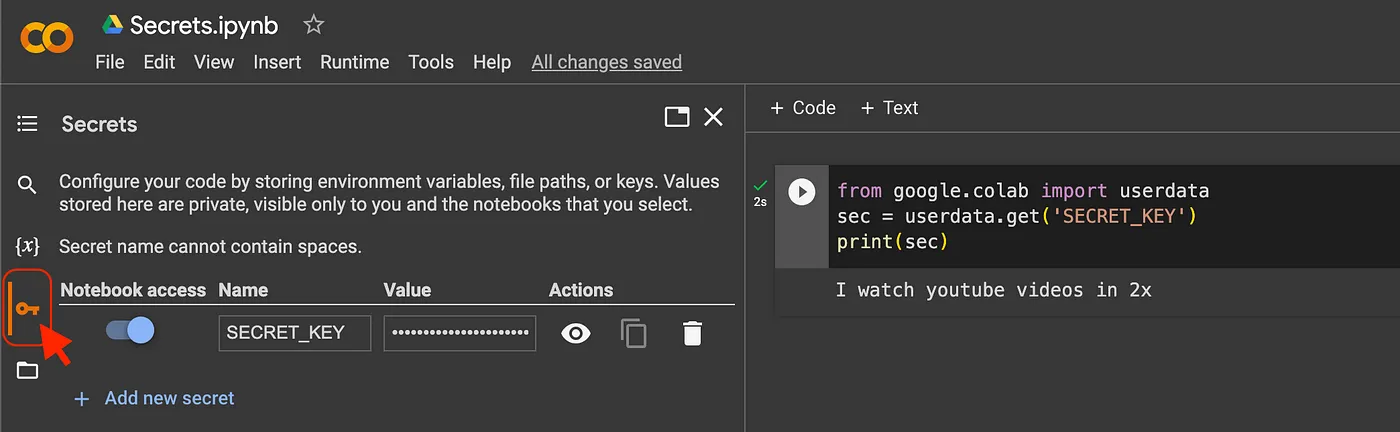

If you have your token [ready in Colab](https://medium.com/@parthdasawant/how-to-use-secrets-in-google-colab-450c38e3ec75), you can directly use it:

In [ ]:
import os
from google.colab import userdata

access_token = userdata.get('SECRET_KEY')

So now you can use `access_token` variable in the code below:

In [ ]:
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import BearerTokenAuth


client = RESTClient(
    base_url="https://api.github.com",
    auth=BearerTokenAuth(token=access_token) # <--- put your token here
)

for page in client.paginate("repos/dlt-hub/dlt/stargazers"):
    print(page)
    break

So now we can rewrite our GitHub dlt pipeline using the RestAPI Client and `access_token`.

In [ ]:
import dlt
from dlt.sources.helpers import requests
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import BearerTokenAuth


# define new resource - github stargazers
@dlt.resource
def github_stargazers():
    client = RESTClient(
        base_url="https://api.github.com",
        auth=BearerTokenAuth(token=access_token)
    )

    for page in client.paginate("repos/dlt-hub/dlt/stargazers"):
        yield page


# define new dlt pipeline
pipeline = dlt.pipeline(destination="duckdb")


# run the pipeline with the new resource
load_info = pipeline.run(github_stargazers)
print(load_info)


# explore loaded data
pipeline.dataset(dataset_type="default").github_stargazers.df()

You can see that all dlt [stargazers](https://github.com/dlt-hub/dlt/stargazers) were loaded into the DuckDB destination.

## **dlt configuration and secrets**

In dlt, [configurations and secrets](https://dlthub.com/docs/general-usage/credentials/) are essential for setting up data pipelines.

**Configurations** are **non-sensitive** settings that define the behavior of a data pipeline, including file paths, database hosts, timeouts, API URLs, and performance settings.

On the other hand, **secrets** are **sensitive** data like passwords, API keys, and private keys, which should never be hard-coded to avoid security risks.

These can be set up in various ways:

* Environment variables
* Within code using `dlt.secrets` and `dlt.config`
* Configuration files (`secrets.toml` and `config.toml`)

We're gonna use `dlt.secrets.value` to define credentials in resources and sources. dlt automatically **extracts** configuration settings and secrets based on flexible naming conventions. It then **injects** these values where needed in code.

**Note**: It's important to note that while you can put all configurations and credentials in the `dlt.secrets` (or `secrets.toml`) if it's more convenient, credentials cannot be placed in `dlt.config` (or `config.toml`) because dlt doesn't look for them there.


Let's create dlt pipeline for both endpoints: `repos/dlt-hub/dlt/stargazers` and `orgs/dlt-hub/events`.

We'll use `@dlt.source` to combine all resources in one place.

In [ ]:
import dlt
from dlt.sources.helpers import requests
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import BearerTokenAuth


@dlt.source
def github_source():
    client = RESTClient(
            base_url="https://api.github.com",
            auth=BearerTokenAuth(token=access_token)
    )

    @dlt.resource
    def github_events():
        for page in client.paginate("orgs/dlt-hub/events"):
            yield page


    @dlt.resource
    def github_stargazers():
        for page in client.paginate("repos/dlt-hub/dlt/stargazers"):
            yield page

    return github_events, github_stargazers

Now we'll use `dlt.secrets.value` in our source to enable dlt secrets configuration. Rename `access_token` variable to `secret_key` because it's already defined.



In [ ]:
exit()

In [ ]:
import dlt
from dlt.sources.helpers import requests
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import BearerTokenAuth


@dlt.source
def github_source(access_token=dlt.secrets.value): # <--- set the secret variable "access_token" here
    client = RESTClient(
            base_url="https://api.github.com",
            auth=BearerTokenAuth(token=access_token)
    )

    @dlt.resource
    def github_events():
        for page in client.paginate("orgs/dlt-hub/events"):
            yield page


    @dlt.resource
    def github_stargazers():
        for page in client.paginate("repos/dlt-hub/dlt/stargazers"):
            yield page

    return github_events, github_stargazers


Configs are defined in a similar way but are accessed using `dlt.config.value`. However, since configuration variables are internally managed by `dlt`, it is unlikely that you would need to explicitly use `dlt.config.value` in most cases.

If you run the pipeline with `secret_key` as `dlt.secrets.value`, you will see the following error:

In [ ]:
# define new dlt pipeline
pipeline = dlt.pipeline(destination="duckdb")


# run the pipeline with the new resource
load_info = pipeline.run(github_source())
print(load_info)

^ That is what happens if you set `dlt.secrets.value` for any variable in your dlt pipeline, but don't set the secret value up.

dlt is looking for secrets in following formats:

```python
ConfigFieldMissingException: Following fields are missing: ['access_token'] in configuration with spec GithubSourceConfiguration
	for field "access_token" config providers and keys were tried in following order:
		In Environment Variables key DLT_COLAB_KERNEL_LAUNCHER__SOURCES____MAIN____GITHUB_SOURCE__ACCESS_TOKEN was not found.
		In Environment Variables key DLT_COLAB_KERNEL_LAUNCHER__SOURCES____MAIN____ACCESS_TOKEN was not found.
		In Environment Variables key DLT_COLAB_KERNEL_LAUNCHER__SOURCES__ACCESS_TOKEN was not found.
		In Environment Variables key DLT_COLAB_KERNEL_LAUNCHER__ACCESS_TOKEN was not found.
		In Environment Variables key SOURCES____MAIN____GITHUB_SOURCE__ACCESS_TOKEN was not found.
		In Environment Variables key SOURCES____MAIN____ACCESS_TOKEN was not found.
		In Environment Variables key SOURCES__ACCESS_TOKEN was not found.
		In Environment Variables key ACCESS_TOKEN was not found.
WARNING: dlt looks for .dlt folder in your current working directory and your cwd (/content) is different from directory of your pipeline script (/usr/local/lib/python3.10/dist-packages).
If you keep your secret files in the same folder as your pipeline script but run your script from some other folder, secrets/configs will not be found
Please refer to https://dlthub.com/docs/general-usage/credentials for more information
```

To define `access_token` secret value we can use:

1. `dlt.secrets` in code (recommended for secret vaults or dynamic creds)
2. Environment variables (recomnended for prod)
3. `secrets.toml` file (recommended for local dev)

### **Use `dlt.secrets` in code**

You can easily rewrite your secret right in the Python code. It's especially convenient if you take credentials from third-party secret providers, or if you want to update credentials and configs dinamically.

In [ ]:
import os
from google.colab import userdata

dlt.secrets["access_token"] = userdata.get('SECRET_KEY')

# define new dlt pipeline
pipeline = dlt.pipeline(destination="duckdb")


# run the pipeline with the new resource
load_info = pipeline.run(github_source())
print(load_info)

Alternatively you can set:

```python
dlt.secrets["sources.access_token"] = userdata.get('SECRET_KEY')
dlt.secrets["sources.____main____.access_token"] = userdata.get('SECRET_KEY')
dlt.secrets["sources.____main____.github_source.access_token"] = userdata.get('SECRET_KEY')
...
```

* `sources` is a special word;

* `__main__` is a python module name;

* `github_source` is the resource name;

* `access_token` is the secret variable name.


So dlt looks for secrets according to this hierarchy:
```
pipeline_name
    |
    |-sources
        |
        |-<module name>
            |  
            |-<source function 1 name>
                |
                |- secret variable 1
                |- secret variable 2
```

To keep the **naming convention** flexible, dlt looks for a lot of **possible combinations** of key names, starting from the most specific possible path. Then, if the value is not found, it removes the right-most section and tries again.


### **Exercise 2: Run pipeline with `dlt.secrets.value`**

Explore the cells above and answer the question below using `sql_client`.

#### Question

Who has id=`17202864` in the `stargazers` table? Use `sql_client`.

---
###  **Use environment variables**

Let's set ENV in the one of the dlt formats: `ACCESS_TOKEN`.


In [ ]:
import os
from google.colab import userdata

os.environ["ACCESS_TOKEN"] = userdata.get('SECRET_KEY')

# define new dlt pipeline
pipeline = dlt.pipeline(destination="duckdb")


# run the pipeline with the new resource
load_info = pipeline.run(github_source())
print(load_info)

Alternatively you can set:

```python
os.environ["SOURCES__ACCESS_TOKEN"] = userdata.get('SECRET_KEY')
os.environ["SOURCES____MAIN____ACCESS_TOKEN"] = userdata.get('SECRET_KEY')
os.environ["SOURCES____MAIN____GITHUB_SOURCE__ACCESS_TOKEN"] = userdata.get('SECRET_KEY')
...
```

**How does it work?**

`dlt` **automatically extracts** configuration settings and secrets based on flexible naming conventions.

It then **injects** these values where needed in functions decorated with `@dlt.source`, `@dlt.resource`, or `@dlt.destination`.


>dlt uses a specific naming hierarchy to search for the secrets and config values. This makes configurations and secrets easy to manage.
>
> The naming convention for **environment variables** in dlt follows a specific pattern. All names are **capitalized** and sections are separated with **double underscores** __ , e.g.  `SOURCES____MAIN____GITHUB_SOURCE__SECRET_KEY`.


---
###  **Use dlt `secrets.toml` or `config.toml`**


> Please note that Colab is not well-suited for using `secrets.toml` or `config.toml` files. As a result, these sections will provide instructions rather than code cells, detailing how to use them in a local environment. You should test this functionality on your own machine. For Colab, it is recommended to use environment variables instead.

The `secrets.toml` file - along with the `config.toml` file - should be stored in the `.dlt` directory where your pipeline code is located:

```
/your_project_directory
│
├── .dlt
│   ├── secrets.toml
│   └── config.toml
│
└── my_pipeline.py
```

Read more about adding [credentials](https://dlthub.com/docs/walkthroughs/add_credentials) here.

To set credentials via TOMLs you would first add your access token to `secrets.toml`:

```toml
# .dlt/secrets.toml

[sources]
secret_key = "your_access_token"
```




Alternatively you can set:

```
[sources]
secret_key = "your_access_token"
```
is equal to:

```
secret_key = "your_access_token"
```

and to:

```
[sources.____main____]
secret_key = "your_access_token"
```
and to:

```
[sources.____main____.github_source]
secret_key = "your_access_token"
```


### **Configure Secrets in Colab**

You can configure secrets using **Secrets** sidebar. Just create a variable with the name `secrets.toml` and paste the content of the toml file from your `.dlt` folder into it. We support `config.toml` variable as well.

Open **Secrets** sidebar, press "Add new secret", create variable with name `secrets.toml` and copy-paste secrets in Value field and Enable it:

```
[sources]
secret_key = "your_access_token"
```


>dlt will not reload the secrets automatically. **Please restart your interpreter** in Colab options when you add/change content of the variables above.

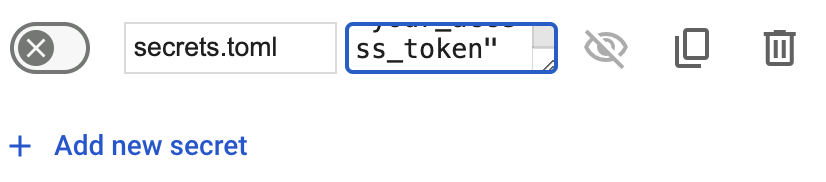

✅ ▶ Proceed to the [next lesson](https://colab.research.google.com/drive/1mfqZulsuFDc7h27d6joe2_Dduvl1uM-2?usp=sharing)!